# **Future Maintenance Dredging**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

,Hs [m]
time,
2012-01-01 00:00:00,1.492622729
2012-01-01 01:00:00,1.564041114
2012-01-01 02:00:00,1.609562006
2012-01-01 03:00:00,1.636151964
2012-01-01 04:00:00,1.638944871


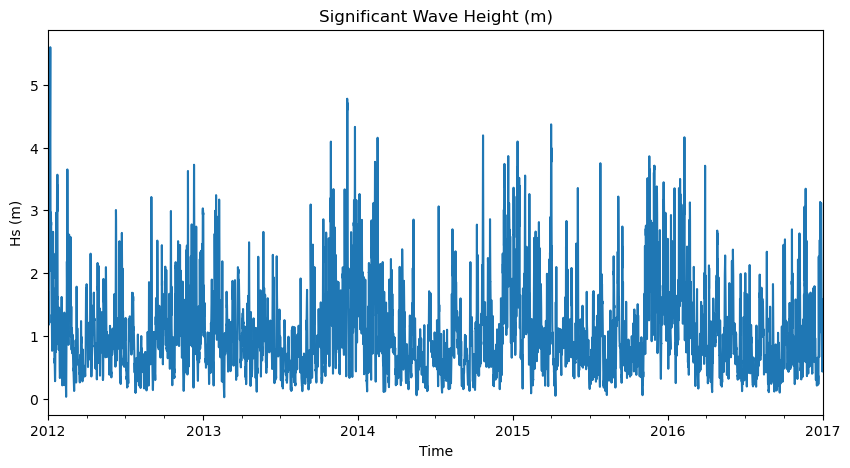

In [3]:
path = Path.cwd()
eurpfm = pd.read_csv(Path.joinpath(path, "Waves_Safe_Haven.csv"), delimiter = ',')
eurpfm['time'] = pd.to_datetime(eurpfm['time'])
eurpfm.set_index(['time'], inplace = True)

display(eurpfm.head(5))
eurpfm.plot(figsize=(10,5), title='Significant Wave Height (m)', ylabel='Hs (m)', xlabel='Time', legend=False);

In [4]:
mean_overal = eurpfm.mean()
print('Mean')
print(mean_overal, "\n", )

print('Standard deviation')
std_overal = eurpfm.std()
print(std_overal)

Mean
Hs [m]   1.061542415649114
dtype: float64 

Standard deviation
Hs [m]   0.6874802644209435
dtype: float64


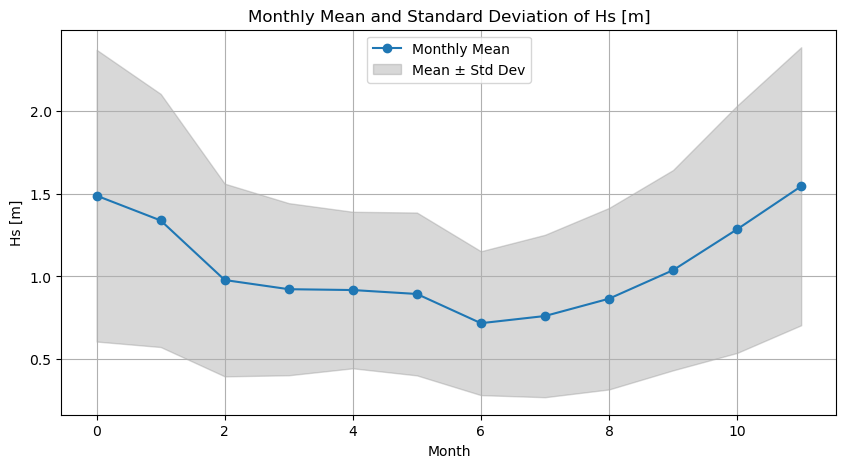

In [5]:
# Group by month (1-12) and calculate mean and std dev for each calendar month across all years
# (monthly_mean and monthly_std already exist)
monthly_mean = eurpfm.groupby(eurpfm.index.month).mean()
monthly_std = eurpfm.groupby(eurpfm.index.month).std()

plt.figure(figsize=(10,5))
plt.plot(monthly_mean.index-1, monthly_mean['Hs [m]'], marker='o', label='Monthly Mean')
plt.fill_between(monthly_mean.index-1,
                 monthly_mean['Hs [m]'] - monthly_std['Hs [m]'],
                 monthly_mean['Hs [m]'] + monthly_std['Hs [m]'],
                 color='gray', alpha=0.3, label='Mean ± Std Dev')
#plt.xticks(ticks=range(12), labels=months)
plt.xlabel('Month')
plt.ylabel('Hs [m]')
plt.title('Monthly Mean and Standard Deviation of Hs [m]')
plt.legend()
plt.grid(True)
plt.show()


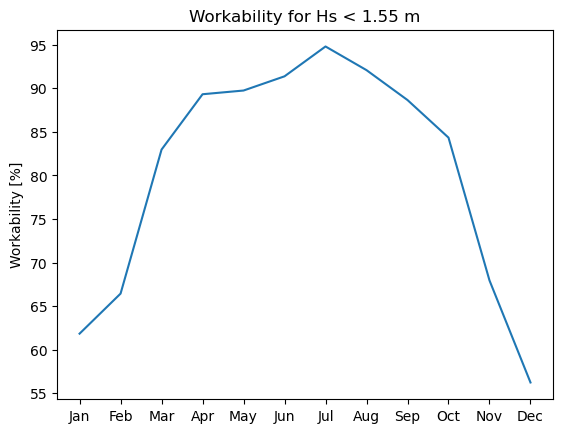

In [6]:
draught= 6.2  #CHANGE WITH BOATS
Hs_thres = 0.25 *draught  #CHANGE WITH BOAT DRAUGHT
work_ability = []

for month in range(1,12+1,1):
    data_month = eurpfm[eurpfm.index.month == month].copy()
    n_all = len(data_month)
    
    data_month = data_month[data_month['Hs [m]'] <= Hs_thres]
    n_workable = len(data_month)
    
    work_ability.append(n_workable/n_all*100)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(work_ability);
plt.xticks(np.linspace(0,11,12), months);
plt.title('Workability for Hs < '+str(Hs_thres)+' m');
plt.ylabel('Workability [%]');

# Persistency

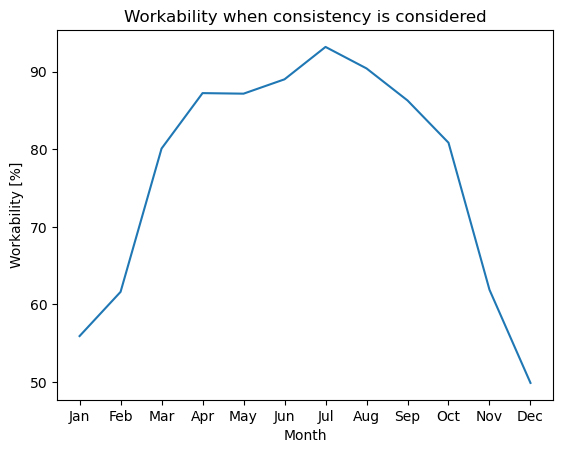

In [7]:
month_assessed = np.zeros(12)# an array that counts how many times each month is reviewed.
month_succes = np.zeros(12)# an array that will count the number of time 6 consequetive hours are occuring


for i in range(len(eurpfm)):
    period = eurpfm.iloc[i:i+6]
    
    month = period.index[0].month
    month_assessed[month-1] += 1# to zero-based

    Hs_serie = period['Hs [m]'].values.tolist()
 
    if np.max(Hs_serie) <= Hs_thres:    
        month_succes[month-1] += 1  # to zero-based
        #print(i, 'succes, Hs', np.max(Hs_serie))
    #else:
    #    print(i, 'not succes, Hs', np.max(Hs_serie), 'Wl min', np.min(WL_serie))

workability = month_succes/month_assessed*100

plt.plot(workability)
plt.title('Workability when consistency is considered')
plt.xticks(np.linspace(0,11,12), months);
plt.xlabel('Month')
plt.ylabel('Workability [%]');


**Using THSD Easydredge 2700 - calculate the production and how much time to dredge 5 m deep sand sediment**

In [65]:
Hopper_capacity = 3700 # m3
suction_diameter = 800 #mm
Power = 940 #kW dredge pump diesel engine
v_TSHD = 12 #knots 
v = 4 #m/s
fraction_sand = 0.35

prod = -6500*suction_diameter/1000 + 1250*(suction_diameter/1000)*np.log(Power)

print('Maximum hourly dry mass production:', round(prod), 'm3/h')
print('Maximum production per week:', round(prod*20*7), 'm3/week')

Maximum hourly dry mass production: 1646 m3/h
Maximum production per week: 230423 m3/week


**Overflow simulation to calculate loading time**

In [66]:
Prod_pipe = v*0.25*np.pi*(suction_diameter/1000)**2
Load_time = Hopper_capacity/Prod_pipe/3600
print(f'Loading time to fill hopper: {round(Load_time*60,0)} minutes \n')
storage = Hopper_capacity # m3

V_cycle = Load_time * prod
V_total = Hopper_capacity # volume of storage
V_water = V_total - V_cycle # volume of water

m_soil = V_cycle *2650 # total mass of soil (dry tons)
m_water = V_water*1025 # total mass of water
m_total = m_soil + m_water # total mass in hopper

rho_mixutre = m_total/V_total # mixture density
print('The average mixture density is ', round(rho_mixutre,0), 'kg/m3')

Loading time to fill hopper: 31.0 minutes 

The average mixture density is  1395.0 kg/m3


In [67]:
rho_mix = 1500
rho_sea = 1025
rho_sand = 2000

sand_fraction = 0.35
settlement_factor = 0.25
trapping_factor = 0.05
overflow_duration = 45 # mins
max_density = 2200
found = False

for overflow_duration_test in range(0, 46):  # 0 to 45 minutes
    solid_percentage = (rho_mix - rho_sea) / (rho_sand - rho_sea)
    mass_dry = prod * rho_sand
    mass_mix = mass_dry / solid_percentage
    volume_mix = mass_mix / rho_mix

    mass_fines_mix = mass_mix * sand_fraction
    mass_fines_stirred = mass_fines_mix * 0.03
    mass_fines_settle = mass_fines_mix - mass_fines_stirred
    mass_overflow = ((Load_time * 60 + overflow_duration_test) / (Load_time * 60)) * (1 - settlement_factor) * (1 - trapping_factor) * mass_fines_settle
    rho_overflow = ((mass_mix - mass_overflow) / mass_mix) * rho_sea + (mass_overflow / mass_mix) * rho_sand

    # stop if density reaches or exceeds max_density (including at 45 min)
    if rho_overflow >= max_density:
        print(f"Maximum allowed overflow duration: {overflow_duration_test} min")
        print(f"Density of overflow water: {rho_overflow:.1f} kg/m³")
        found = True
        break

    if not found:
     # did not reach max density within 0-45 min -> force use of 45 min
        overflow_duration_test = 45
print("Overflow density did not reach 2200 kg/m³ within 45 minutes. Using 45 min as overflow duration.")
print(f"Density of overflow water at 45 min: {rho_overflow:.1f} kg/m³")

t_loading = Load_time*60 + (overflow_duration_test) # total cycle time (min)
print(f"Loading time without overflow: {Load_time*60:.0f} mins")
print(f"Total time loading: {t_loading:.0f} mins")

# 🔹 Sand volume and mass per cycle
solid_fraction = (rho_mix - rho_sea) / (rho_sand - rho_sea)
sand_volume_cycle = Hopper_capacity * solid_fraction
sand_mass_cycle = sand_volume_cycle * rho_sand

print(f"Sand volume per cycle: {sand_volume_cycle:.1f} m³")
print(f"Sand mass per cycle: {sand_mass_cycle/1000:.1f} tonnes")


Overflow density did not reach 2200 kg/m³ within 45 minutes. Using 45 min as overflow duration.
Density of overflow water at 45 min: 1606.9 kg/m³
Loading time without overflow: 31 mins
Total time loading: 76 mins
Sand volume per cycle: 1802.6 m³
Sand mass per cycle: 3605.1 tonnes


In [68]:
beach_distance = 3 #km
v_TSHD = v_TSHD*0.514*60 #convert to m/minute
t_sailing = beach_distance*1000/v_TSHD #in minutes
t_discharge = 10
t_maneuvering = 15
t_cycle = t_loading + t_sailing + t_discharge + t_sailing*0.9 +t_maneuvering
print(f"Total cycle time: {t_cycle:.1f} mins")
print(f"Sailing time: {t_sailing:.1f} mins")
print(f"Discharge time: {t_discharge:.1f} mins")
print(f"Maneuvering time: {t_maneuvering:.1f} mins")


Total cycle time: 116.1 mins
Sailing time: 8.1 mins
Discharge time: 10.0 mins
Maneuvering time: 15.0 mins


**INITIAL DREDGING: Volumes and Days required**

In [69]:
def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1

V_sand_1, B_top_sand_1 = V_trench(B = 220,H = 5.75,phi = 30, L=1000) 
print('Initial Maintenance:', round(V_sand_1,0) ,'m3, top width:', round(B_top_sand_1,0), 'm')

n_cycles_1 = V_sand_1/sand_volume_cycle
total_cycle_minutes_1 = n_cycles_1 * t_cycle
total_working_hours_1 = total_cycle_minutes_1 / 60
total_days_1 = total_working_hours_1 / 20
total_weeks_1 = total_days_1 / 7
print(f'Total days required to perform initial dredging: {total_days_1:.1f} days')
print(f'Total weeks required to perform initial dredging: {total_weeks_1:.1f} weeks')

# only use the top N highest workability months to compute average
top_n = 4
top_n = min(top_n, len(workability))
top_values = np.sort(workability)[-top_n:]
avg_workability_pct = np.mean(top_values)  # percent using only top_n months

calendar_weeks_required_1 = total_weeks_1 / (avg_workability_pct / 100)

print(f'Number of cycles: {n_cycles_1:.1f}')
print(f'Average workability: {avg_workability_pct:.1f}%')
print(f'Total working weeks (calendar) considering workability: {calendar_weeks_required_1:.0f} weeks')



Initial Maintenance: 1322266.0 m3, top width: 240.0 m
Total days required to perform initial dredging: 71.0 days
Total weeks required to perform initial dredging: 10.1 weeks
Number of cycles: 733.5
Average workability: 89.9%
Total working weeks (calendar) considering workability: 11 weeks


**SECOND MAINTENANCE DREDGING: Volumes and Days required**

In [79]:
V_sand2, B_top_sand2 = V_trench(B = 220,H = 14.5-8.18,phi = 30, L=1000) 
print('Second maintenance:', round(V_sand2,0) ,'m3, top width:', round(B_top_sand2,0), 'm')

n_cycles_2 = V_sand2/sand_volume_cycle
total_cycle_minutes_2 = n_cycles_2 * t_cycle
total_working_hours_2 = total_cycle_minutes_2 / 60
total_days_2 = total_working_hours_2 / 20
total_weeks_2 = total_days_2 / 7
print(f'Total days required to perform second dredging: {total_days_2:.1f} days')
print(f'Total weeks required to perform second dredging: {total_weeks_2:.1f} weeks')

# only use the top N highest workability months to compute average
top_n = 3
top_n = min(top_n, len(workability))
top_values = np.sort(workability)[-top_n:]
avg_workability_pct = np.mean(top_values)  # percent using only top_n months

calendar_weeks_required_2 = total_weeks_2 / (avg_workability_pct / 100)

print(f'Number of cycles: {n_cycles_2:.1f}')
print(f'Average workability: {avg_workability_pct:.1f}%')
print(f'Total working weeks (calendar) considering workability: {calendar_weeks_required_2:.0f} weeks')

Second maintenance: 1459582.0 m3, top width: 242.0 m
Total days required to perform second dredging: 78.3 days
Total weeks required to perform second dredging: 11.2 weeks
Number of cycles: 809.7
Average workability: 90.9%
Total working weeks (calendar) considering workability: 12 weeks


**Channel depth evolution in 10 years period of maintenance**

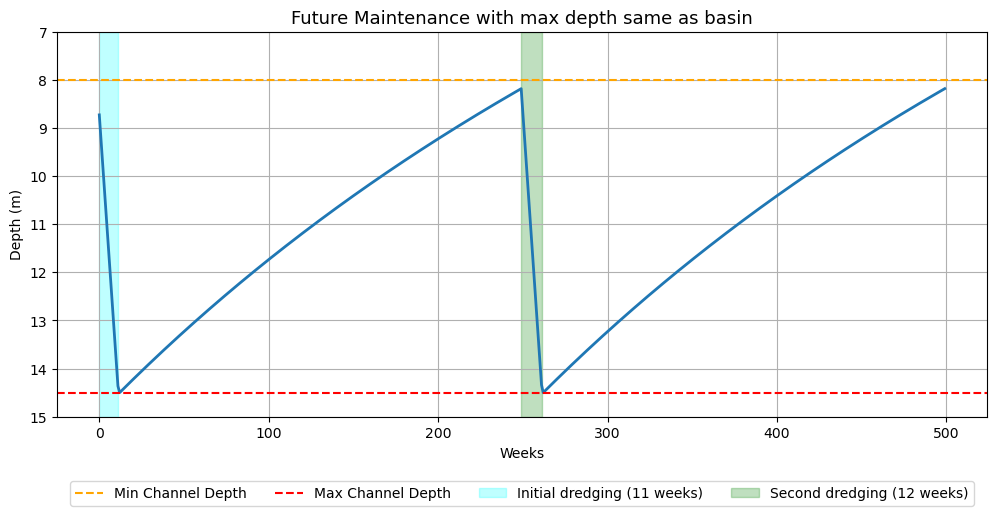

In [81]:
rho_sand = 2000        # sediment density (kg/m³)
length = 1000          # channel length (m)
depth_start = 14.5      # initial depth (m)
depth_threshold = 8     # threshold depth for reference
B_top_sand = 220       # top width at 8 m depth (m)
width_at_8m = B_top_sand
slant_angle = 30       # side slope (degrees)
tan_phi = np.tan(np.radians(slant_angle))

weeks = 500
maintenance_start_week = 250   # week to start dredging

# simulate 10-year channel evolution with both initial and second maintenance dredging events
init_maintenance_week = 1                      # schedule initial dredging at week 1
dur_init = calendar_weeks_required_1           # weeks to restore for initial dredging
second_maintenance_week = maintenance_start_week
dur_second = calendar_weeks_required_2         # weeks to restore for second dredging

depth0 = 8.75
depth = depth0
depth_history = []
in_maintenance = False
maintenance_timer = 0
maintenance_duration = 0

for t in range(weeks):
    if in_maintenance:
        remaining = maintenance_duration - maintenance_timer
        if remaining > 0:
            dredge_rate = (depth_start - depth) / remaining
        else:
            dredge_rate = (depth_start - depth)
        depth += dredge_rate
        maintenance_timer += 1
        if maintenance_timer >= maintenance_duration:
            in_maintenance = False
            maintenance_timer = 0
            depth = depth_start
    else:
        effective_width = max(width_at_8m - max(depth - 8, 0) * tan_phi, 1.0)
        S = (250*15 + 270*depth**1.4) * length / rho_sand  # m³/week
        d_change = S / (effective_width * length)
        depth -= d_change

        if (t + 1) == init_maintenance_week:
            in_maintenance = True
            maintenance_duration = dur_init
            maintenance_timer = 0
        elif (t + 1) == second_maintenance_week:
            in_maintenance = True
            maintenance_duration = dur_second
            maintenance_timer = 0

    depth_history.append(depth)

# Plot corrected result and compare with previous simulation
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(depth_history)), depth_history, linewidth=2)
plt.axhline(depth_threshold, linestyle='--', color='orange', label='Min Channel Depth')
plt.axhline(depth_start, linestyle='--', color='red', label='Max Channel Depth')
plt.axvspan(init_maintenance_week-1, init_maintenance_week-1 + dur_init,
            color='cyan', alpha=0.25, label=f'Initial dredging ({dur_init:.0f} weeks)')
plt.axvspan(second_maintenance_week-1, second_maintenance_week-1 + dur_second,
            color='green', alpha=0.25, label=f'Second dredging ({dur_second:.0f} weeks)')
plt.gca().invert_yaxis()
plt.title("Future Maintenance with max depth same as basin", fontsize=13)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=4, frameon=True)
plt.ylim(15,7)
plt.xlabel("Weeks")
plt.ylabel("Depth (m)")
plt.grid(True)
plt.show()

# place legend below the plot



In [74]:
# print depth at week 260 (1-based week numbering)
week = 250
idx = week - 1
if 0 <= idx < len(depth_history):
    print(f"Depth at week {week}: {depth_history[idx]:.2f} m")
else:
    print(f"Week {week} is out of range (0-{len(depth_history)-1})")

Depth at week 250: 8.18 m
